# Project: Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Read in the dataset and take a look at the top few rows here:

In [2]:
#load the data
df = pd.read_csv('ab_data.csv')
df.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


Number of rows in the dataset.

In [3]:
#number of samples
print('The number of rows in the dataset:',df.shape[0])

The number of rows in the dataset: 294478


The number of unique users in the dataset.

In [4]:
#number of unique users
print('The number of unique users in the dataset:',df['user_id'].nunique())

The number of unique users in the dataset: 290584


The proportion of users converted.

In [5]:
# conversion rate regardless of the group
conv = df[df['converted'] == 1]['user_id'].nunique()
no_conv = df[df['converted'] == 0]['user_id'].nunique()

print('The proportion of users converted:' , (conv / (conv + no_conv)))

The proportion of users converted: 0.1206836210919272


The number of times the new_page and treatment don't match.

In [6]:
# number of mismatches
non_match = np.add(df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].shape[0] , 
                   df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].shape[0])

In [7]:
print("The number of times the new_page and treatment don't match:", non_match)

The number of times the new_page and treatment don't match: 3893


Any of the rows have missing values?

In [8]:
# nulls in each columns
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page, so we will drop these rows and store it in new dataframe.

In [9]:
# getting those wrong mismatches and appending them
wrng1 = df[(df['group'] == 'control')   & (df['landing_page'] == 'new_page')].index
wrng2 = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].index

wrng = wrng1 | wrng2

In [10]:
#dropping the mismatches
df2 = df.drop(wrng)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

How many unique **user_id**s are in **df2**?

In [12]:
#unique users after dropping mismatches
print("The number of unique ids in df2:", df2['user_id'].nunique())

The number of unique ids in df2: 290584


In [13]:
#all rows in df2
df2.shape[0]
print("The number of ids in df2:", df2.shape[0])

The number of ids in df2: 290585


There is one **user_id** repeated in **df2**.  What is it?

In [14]:
# getting the duplicated user index
print("The user_id for the non-unique id in df2:\n", df2['user_id'].value_counts().head(1))

The user_id for the non-unique id in df2:
 773192    2
Name: user_id, dtype: int64


What is the row information for the repeat **user_id**? 

In [15]:
# seeing information of the duplicated user
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
#dropping one row of them
df2 = df2.drop(1899)

What is the probability of an individual converting regardless of the page they receive?

In [17]:
# conversion rate regardless of page
print("Probability of converting regardless of page:",df2[df2['converted'] == 1].shape[0] / df2.shape[0])

Probability of converting regardless of page: 0.11959708724499628


Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
# probability of conversion rate for control group
cnv_ctrl = df2[(df2['group'] == 'control') & (df2['converted'] == 1)].shape[0]
ctrl = df2[df2['group'] == 'control'].shape[0]

prob = cnv_ctrl / ctrl
print('''Given that an individual was in the control group,
the probability of converting:''' ,prob)

Given that an individual was in the control group,
the probability of converting: 0.1203863045004612


Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
# probability of conversion rate for treatment group
cnv_trtmnt = df2[(df2['group'] == 'treatment') & (df2['converted'] == 1)].shape[0]
trtmnt      = df2[df2['group'] == 'treatment'].shape[0]

prob = cnv_trtmnt / trtmnt
print('''Given that an individual was in the treatment group,
the probability of converting:''' ,prob)

Given that an individual was in the treatment group,
the probability of converting: 0.11880806551510564


What is the probability that an individual received the new page?

In [20]:
# probability of landing pages
print("The probability of receiving the new page:",(df['landing_page'] == 'new_page').mean())

The probability of receiving the new page: 0.5


Considering the results above, There is no sufficient evidence to conclude that the new treartment page leads to more conversions as landing a new page is 50%, and 12% of the control group converted, and 11% of the treatment group converted. so in conclusion, that didn't increase the conversion rate. there is more information needed to be gathered in order to know wether the new treatment page will lead to more conversions or not.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, consider we need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, Then our     
   Null hypotheses:               $p_{old}$ >= $p_{new}$   
   Alternative hypotheses:        $p_{old}$ <  $p_{new}$

<br><br>Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.

Using a sample size for each page equal to the ones in **ab_data.csv**.

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

Using the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.

What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
#conversion rate for trearment group
p_new = (df2['converted'] == 1).mean()
print('p_new under the null:',p_new)

p_new under the null: 0.11959708724499628


What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
#conversion rate for control group
p_old = (df2['converted'] == 1).mean()
print('p_old under the null:',p_old)

p_old under the null: 0.11959708724499628


What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
# number of user in treatment group
n_new = df2[df2['group'] == 'treatment'].shape[0]
print('n_new:',n_new)

n_new: 145310


What is $n_{old}$, the number of individuals in the control group?

In [24]:
# number of users in control group
n_old = df2[df2['group'] == 'control'].shape[0]
print('n_old:',n_old)

n_old: 145274


Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
# simulating conversions for treatment group
new_page_converted = np.random.choice([0 , 1], size = n_new,
                                      p = [(1-p_new) , p_new])

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
# simulating conversions for control group
old_page_converted = np.random.choice([0 , 1], size = n_old,
                                      p = [(1-p_old) , p_old])

Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
# difference between conversion rates
new_page_converted.mean() - old_page_converted.mean()

0.0017734007037219085

Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
#simulating 10,000 times
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

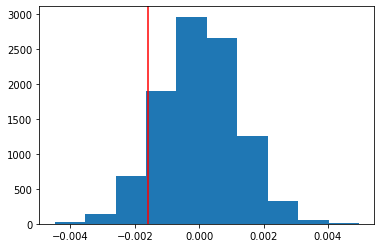

In [29]:
#histogram plotting the conversion differences
plt.hist(p_diffs);
plt.axvline((cnv_trtmnt / trtmnt) - (cnv_ctrl / ctrl),
            color = 'red');

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
#calculating p-value
(np.array(p_diffs) > (cnv_trtmnt / trtmnt) - (cnv_ctrl / ctrl)).mean()

0.907

We've just computed the p-value, which is the probability of the alternative hypothesis against the null hypothesis, the smaller the p-value, the stronger that we should reject the null hypothesis.

and since this value is larger than the type 1 error, we fail to reject the null hypothesis, which means that the new page doesn't lead to more conversion rate.

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
# using statsmodel to calculate p-value
import statsmodels.api as sm

convert_old = df2[(df2['converted'] == 1) & (df2['landing_page'] == 'old_page')].shape[0]
convert_new = df2[(df2['converted'] == 1) & (df2['landing_page'] == 'new_page')].shape[0]
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]

Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [33]:
# getting p-value
stat, pval = sm.stats.proportions_ztest(count=[convert_new , convert_old],
                                        nobs=[n_new , n_old],
                                        alternative='larger')
print(stat, pval)

-1.3109241984234394 0.9050583127590245


the z-score means that the conversion rate for people landing the new page is on average  1.3 lower than conversion rate from people landing the old page

and the p-value means that we fail to reject the null hypotheses and that old page leads to a higher conversion rate

<a id='regression'></a>
### Part III - A regression approach
In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

Since each row is either a conversion or no conversion, we should you be performing logistic regression in this case

The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
#adding intercept and dummy variable
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

Using **statsmodels** to instantiate our regression model on the two columns we created, then fit the model using the two columns we created to predict whether or not an individual converts. 

In [35]:
#initiatemodel
model = sm.Logit(df2['converted'] , df2[['intercept' , 'ab_page']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Providing the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
#model summary
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-05-01 07:52 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

p-value here is 0.18, it differs since the p value is calcualated as >|z| which means its two sided, then a one side is 0.09, which conlude that the p value is  
***1 - 0.09 = 0.91***,
which is same as our calculated p-value.

***the statsmodel hypotheses :***

    H0: pnew−pold=0
    H1: pnew−pold≠0

its a good idea to look for other factors to add into your regression model, as the factors we have aren't significant, one disadvantage of that might be complexity of the model will increase and multicollinearity might occur.

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. We will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.

Does it appear that country had an impact on conversion?

In [37]:
# adding countries to dataframe
cntr = pd.read_csv('countries.csv')
df2 = df2.join(cntr.set_index('user_id'), on= 'user_id',how='inner')
df2.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US


In [38]:
#getting dummy variables for countries
df2[['UK' , 'US']] = pd.get_dummies(df2['country'],drop_first=True)

In [39]:
#initiate the model
model = sm.Logit(df2['converted'] , df2[['intercept' , 'ab_page' , 'UK' , 'US']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [40]:
#model summary
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-05-01 07:56 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

Even countries doesn't have a significant effect

Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [41]:
# setting up interaction of pages and countries
df2['ab_UK'] = df2['ab_page'] * df2['UK']
df2['ab_US'] = df2['ab_page'] * df2['US']

In [42]:
#initiate model
model = sm.Logit(df2['converted'] , df2[['intercept', 'ab_page',
                                         'UK' , 'US',
                                         'ab_UK', 'ab_US']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [43]:
#model summary
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-05-01 07:57 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
ab_UK          0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
ab_US          0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

## Conclusion

With what we have, there is no strong evidence that the new page increases the conversion rate, non of the variables made a signifigance, so it will be best to focus on creating a new page